In [2]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [3]:
!unzip datasets.zip
!ls

Archive:  datasets.zip
  inflating: style_reference/composition_8.jpg  
  inflating: style_reference/cow.jpg  
  inflating: style_reference/inwang_jesaekdo.jpg  
  inflating: style_reference/in_the_car.jpg  
  inflating: style_reference/la_yole.jpg  
  inflating: style_reference/sunflower.jpg  
  inflating: style_reference/the_scream.jpg  
  inflating: style_reference/the_starry_night.jpg  
  inflating: target/cat.jpg          
  inflating: target/disney.jpg       
  inflating: target/landscape.jpg    
  inflating: target/lena.png         
  inflating: target/portrait.jpg     
datasets.zip  sample_data  style_reference  target


In [4]:
from keras.preprocessing.image import load_img, img_to_array, save_img
import numpy as np
from keras.applications import vgg19
from keras import backend as K
from scipy.optimize import fmin_l_bfgs_b
import time
import os

target_image_path = './target'
style_reference_image_path = './style_reference'
target_images = [os.path.join(r,file) for r,d,f in os.walk(target_image_path) for file in f]
style_reference_images = [os.path.join(r,file) for r,d,f in os.walk(style_reference_image_path) for file in f]

print(target_images)
print(style_reference_images)

Using TensorFlow backend.


['./target/portrait.jpg', './target/landscape.jpg', './target/lena.png', './target/cat.jpg', './target/disney.jpg']
['./style_reference/composition_8.jpg', './style_reference/cow.jpg', './style_reference/in_the_car.jpg', './style_reference/sunflower.jpg', './style_reference/inwang_jesaekdo.jpg', './style_reference/the_starry_night.jpg', './style_reference/the_scream.jpg', './style_reference/la_yole.jpg']


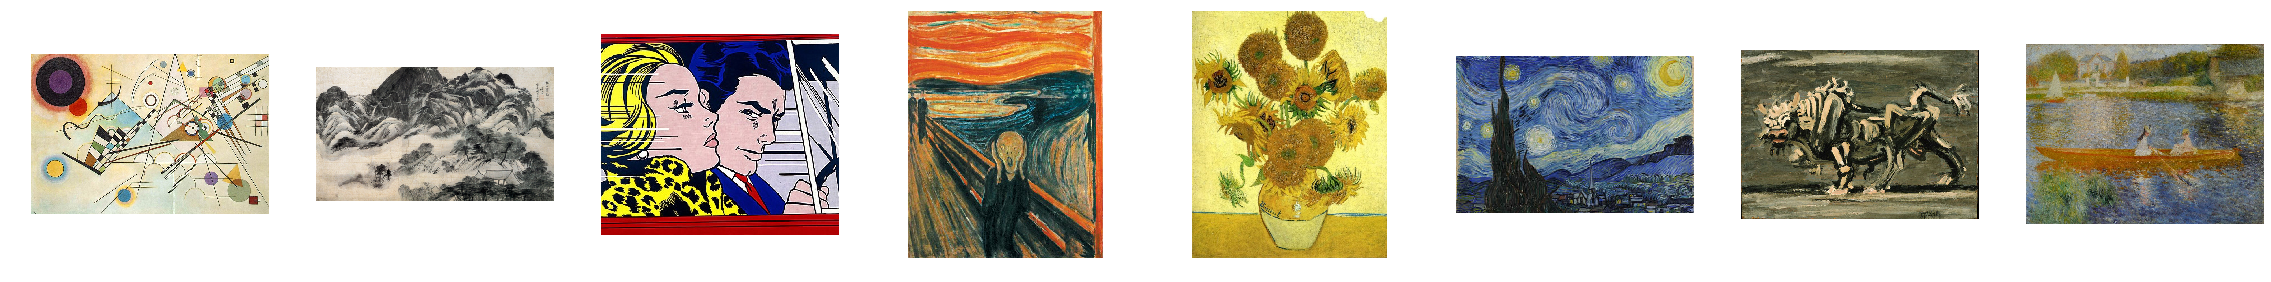

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in style_reference_images:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(40, 10))
columns = 8
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

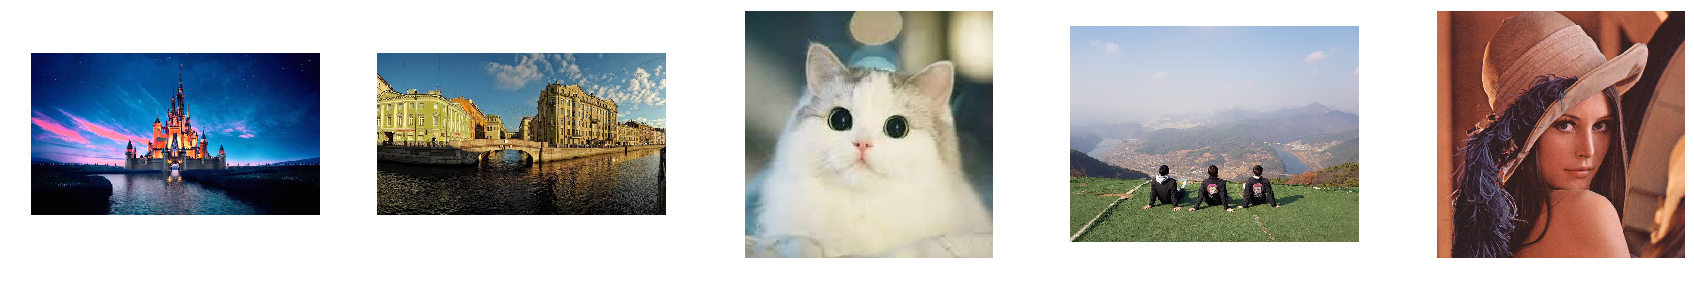

In [5]:
images = []
for img_path in target_images:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(30, 10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

In [0]:
class NeuralST:
  
  def __init__(self, target_image, style_reference_image):
    self.target_image = target_image
    self.style_reference_image = style_reference_image
    width, height = load_img(target_image).size
    self.img_height = 400
    self.img_width = int(width * self.img_height / height)
    
  def preprocess_image(self, image_path):
    img = load_img(image_path, target_size=(self.img_height, self.img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img
  
  def deprocess_image(self, x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x
  
  def load_model(self):
    self.target_image = K.constant(self.preprocess_image(self.target_image))
    self.style_reference_image = K.constant(self.preprocess_image(self.style_reference_image))
    self.combination_image = K.placeholder((1, self.img_height, self.img_width, 3))

    self.input_tensor = K.concatenate([self.target_image,
                                 self.style_reference_image,
                                 self.combination_image], axis=0)

    self.model = vgg19.VGG19(input_tensor=self.input_tensor,
                         weights='imagenet',
                         include_top=False)
    print('Model loaded.')

In [0]:
class Evaluator(object):
  def __init__(self, height, width):
    self.loss_value = None
    self.grads_values = None
    self.img_height = height
    self.img_width = width
    
  def content_loss(self, base, combination):
    return K.sum(K.square(combination - base))
  
  def gram_matrix(self, x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

  def style_loss(self, style, combination):
    S = self.gram_matrix(style)
    C = self.gram_matrix(combination)
    channels = 3
    size = self.img_height * self.img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
  
  def total_variation_loss(self, x):
    a = K.square(
      x[:, :self.img_height - 1, :self.img_width -1, :] -
      x[:, 1:, :self.img_width - 1, :])
    b = K.square(
      x[:, :self.img_height - 1, :self.img_width - 1, :] - \
      x[:, :self.img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))
  
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, self.img_height, self.img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grads_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grads_values = grads_values
    return self.loss_value
  
  def grads(self, x):
    assert self.loss_value is not None
    grads_values = np.copy(self.grads_values)
    self.loss_value = None
    self.grads_values = None
    return grads_values

In [9]:
content_layer = 'block4_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
style_weight = 1.
content_weight = 0.025

for i, target in enumerate(target_images):
  for j, style in enumerate(style_reference_images):
    print('[Model %d-%d]' % (i , j))
    neural_style = NeuralST(target, style)
    neural_style.load_model()
    evaluator = Evaluator(neural_style.img_height, neural_style.img_width)
    
    outputs_dict = dict([(layer.name, layer.output) for layer in neural_style.model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict[content_layer]
    target_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * evaluator.content_loss(target_image_features,
                                         combination_features)

    for layer_name in style_layers:
      layer_features = outputs_dict[layer_name]
      style_reference_features = layer_features[1, :, :, :]
      combination_features = layer_features[2, :, :, :]
      sl = evaluator.style_loss(style_reference_features, combination_features)
      loss += (style_weight / len(style_layers)) * sl
    
    grads = K.gradients(loss, neural_style.combination_image)[0]

    fetch_loss_and_grads = K.function([neural_style.combination_image], [loss, grads])
    
    result_prefix = 'style_transfer_result_%d_%d' % (i, j)
    iterations = 20

    x = neural_style.preprocess_image(target)
    x = x.flatten()
    for k in range(iterations):
      print('Step %d / %d: ' % (k + 1, iterations))
      start_time = time.time()
      x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                      x,
                                      fprime=evaluator.grads,
                                      maxfun=20)
      end_time = time.time()
      print('loss: %d \tprocessing time: %ds' % (min_val, end_time - start_time))
      if k == 19:
        img = x.copy().reshape((neural_style.img_height, neural_style.img_width, 3))
        img = neural_style.deprocess_image(img)
        fname = result_prefix + '_at_iteration_20.png'
        save_img(fname, img)
    print('-'*30)

[Model 0-0]
Model loaded.
Step 1 / 20: 
loss: 32649199616 	processing time: 26s
Step 2 / 20: 
loss: 25931761664 	processing time: 18s
Step 3 / 20: 
loss: 23912126464 	processing time: 18s
Step 4 / 20: 
loss: 22871691264 	processing time: 18s
Step 5 / 20: 
loss: 22231914496 	processing time: 18s
Step 6 / 20: 
loss: 21809262592 	processing time: 18s
Step 7 / 20: 
loss: 21482250240 	processing time: 18s
Step 8 / 20: 
loss: 21200250880 	processing time: 18s
Step 9 / 20: 
loss: 20988792832 	processing time: 18s
Step 10 / 20: 
loss: 20808757248 	processing time: 18s
Step 11 / 20: 
loss: 20663429120 	processing time: 18s
Step 12 / 20: 
loss: 20539269120 	processing time: 18s
Step 13 / 20: 
loss: 20423899136 	processing time: 18s
Step 14 / 20: 
loss: 20324378624 	processing time: 18s
Step 15 / 20: 
loss: 20237426688 	processing time: 18s
Step 16 / 20: 
loss: 20159899648 	processing time: 18s
Step 17 / 20: 
loss: 20088473600 	processing time: 18s
Step 18 / 20: 
loss: 20017393664 	processing tim

In [10]:
model_names = []
img_pathes = []
for i in range(5):
  for j in range(8):
    img_pathes.append('./style_transfer_result_%d_%d_at_iteration_20.png' % (i, j))

images = []
for img_path in img_pathes:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(40, 25))
columns = 8
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [7]:
content_layer = 'block4_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

style_weights = [1., 5., 20., 100., 1000.]
content_weight = 0.025

target = './target/landscape.jpg'
style = './style_reference/the_scream.jpg'

for style_weight in style_weights:
  neural_style = NeuralST(target, style)
  print('[Model with content/style ratio %f]' % (content_weight / style_weight))
  neural_style.load_model()
  evaluator = Evaluator(neural_style.img_height, neural_style.img_width)

  outputs_dict = dict([(layer.name, layer.output) for layer in neural_style.model.layers])

  loss = K.variable(0.)
  layer_features = outputs_dict[content_layer]
  target_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  loss += content_weight * evaluator.content_loss(target_image_features,
                                       combination_features)

  for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = evaluator.style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

  grads = K.gradients(loss, neural_style.combination_image)[0]

  fetch_loss_and_grads = K.function([neural_style.combination_image], [loss, grads])

  iterations = 20

  x = neural_style.preprocess_image(target)
  x = x.flatten()
  for k in range(iterations):
    print('Step %d / %d: ' % (k + 1, iterations))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                    x,
                                    fprime=evaluator.grads,
                                    maxfun=20)
    end_time = time.time()
    print('loss: %d \tprocessing time: %.2fs' % (min_val, end_time - start_time))
    if k == 19:
      img = x.copy().reshape((neural_style.img_height, neural_style.img_width, 3))
      img = neural_style.deprocess_image(img)
      fname = 'style_transfer_result_ratio_%f.png' % (content_weight / style_weight)
      save_img(fname, img)
  print('-'*30)

[Model with content/style ratio 0.025000]
80142336/80134624 [==============================] - 1s 0us/step
Model loaded.
Step 1 / 20: 
loss: 11332662272 	processing time: 26.97s
Step 2 / 20: 
loss: 10233575424 	processing time: 18.90s
Step 3 / 20: 
loss: 9879617536 	processing time: 19.00s
Step 4 / 20: 
loss: 9709280256 	processing time: 19.14s
Step 5 / 20: 
loss: 9595502592 	processing time: 19.44s
Step 6 / 20: 
loss: 9513053184 	processing time: 19.39s
Step 7 / 20: 
loss: 9451442176 	processing time: 19.45s
Step 8 / 20: 
loss: 9404806144 	processing time: 19.50s
Step 9 / 20: 
loss: 9365837824 	processing time: 19.55s
Step 10 / 20: 
loss: 9331362816 	processing time: 19.64s
Step 11 / 20: 
loss: 9304498176 	processing time: 19.51s
Step 12 / 20: 
loss: 9280658432 	processing time: 19.60s
Step 13 / 20: 
loss: 9260168192 	processing time: 19.53s
Step 14 / 20: 
loss: 9243122688 	processing time: 19.66s
Step 15 / 20: 
loss: 9226992640 	processing time: 19.56s
Step 16 / 20: 
loss: 9212701696

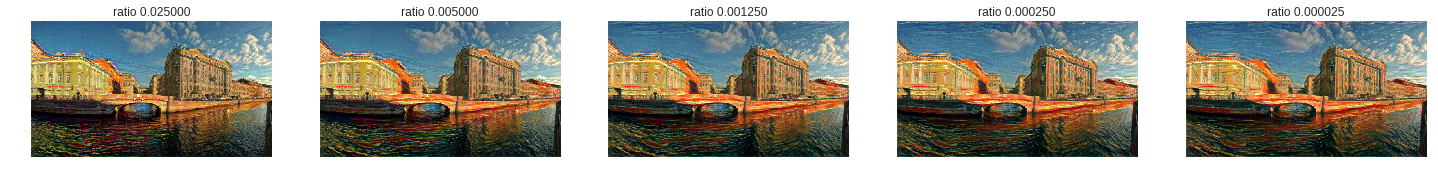

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for style_weight in style_weights:
  img_path = './style_transfer_result_ratio_%f.png' % (content_weight / style_weight)
  images.append(mpimg.imread(img_path))

plt.figure(figsize=(25, 10))
columns = 5
for i, (image, style_weight) in enumerate(zip(images, style_weights)):
    plt.subplot(len(images) / columns + 1, columns, i + 1).set_title('ratio %f' % (content_weight / style_weight))
    plt.imshow(image)
    plt.axis('off')

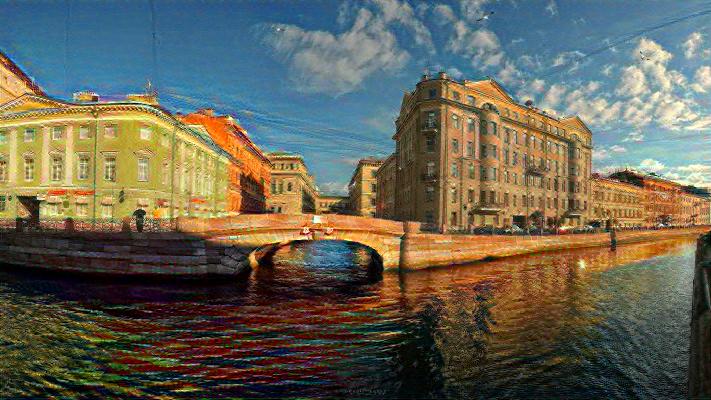

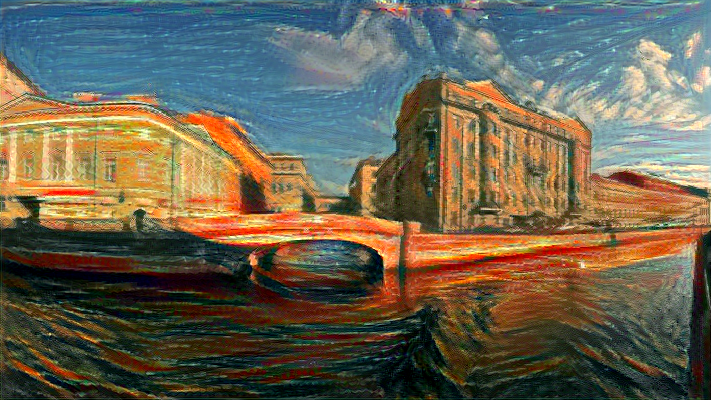

In [9]:
from IPython.display import Image, display

listOfImageNames = ['./style_transfer_result_ratio_0.025000.png',
                    './style_transfer_result_ratio_0.000025.png']

for imageName in listOfImageNames:
    display(Image(filename=imageName))